In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, FashionMNIST
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import animation, rc


In [2]:
BATCH_SIZE = 100

In [3]:
trainval_data = MNIST("./data", train=True,download=True,transform=transforms.ToTensor())

In [4]:
train_size = int(len(trainval_data) * 0.8)
val_size = int(len(trainval_data) * 0.2)

In [5]:
train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])

In [6]:
train_loader = DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True,num_workers=0)

In [7]:
val_loader = DataLoader(dataset=val_data,batch_size=BATCH_SIZE,shuffle=True, num_workers=0)

In [8]:
print("train data size: ",len(train_data)) 

train data size:  48000


In [9]:
print("train iteration number: ",len(train_data)//BATCH_SIZE) 

train iteration number:  480


In [10]:
print("val data size: ",len(val_data))  

val data size:  12000


In [11]:
print("val iteration number: ",len(val_data)//BATCH_SIZE) 

val iteration number:  120


In [12]:
images, labels = next(iter(train_loader))

In [13]:
print("images_size:",images.size())

images_size: torch.Size([100, 1, 28, 28])


In [14]:
print("label:",labels[:10])

label: tensor([5, 6, 9, 3, 7, 0, 7, 7, 2, 7])


In [15]:
image_numpy = images.detach().numpy().copy()

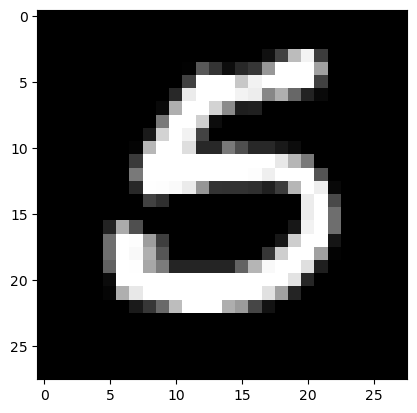

In [16]:
plt.imshow(image_numpy[0,0,:,:], cmap='gray')

In [17]:
class Encoder(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(28*28, 300)
    self.lr2 = nn.Linear(300, 100)
    self.lr_ave = nn.Linear(100, z_dim)   #average
    self.lr_dev = nn.Linear(100, z_dim)   #log(sigma^2)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    x = self.lr(x)
    x = self.relu(x)
    x = self.lr2(x)
    x = self.relu(x)
    ave = self.lr_ave(x)    #average
    log_dev = self.lr_dev(x)    #log(sigma^2)

    ep = torch.randn_like(ave)   #平均0分散1の正規分布に従い生成されるz_dim次元の乱数
    z = ave + torch.exp(log_dev / 2) * ep   #再パラメータ化トリック
    return z, ave, log_dev

In [18]:
class Decoder(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(z_dim, 100)
    self.lr2 = nn.Linear(100, 300)
    self.lr3 = nn.Linear(300, 28*28)
    self.relu = nn.ReLU()
  
  def forward(self, z):
    x = self.lr(z)
    x = self.relu(x)
    x = self.lr2(x)
    x = self.relu(x)
    x = self.lr3(x)
    x = torch.sigmoid(x)   #MNISTのピクセル値の分布はベルヌーイ分布に近いと考えられるので、シグモイド関数を適用します。
    return x

In [19]:
class VAE(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.encoder = Encoder(z_dim)
    self.decoder = Decoder(z_dim)
  
  def forward(self, x):
    z, ave, log_dev = self.encoder(x)
    x = self.decoder(z)
    return x, z, ave, log_dev
  
def criterion(predict, target, ave, log_dev):
  bce_loss = F.binary_cross_entropy(predict, target, reduction='sum')
  kl_loss = -0.5 * torch.sum(1 + log_dev - ave**2 - log_dev.exp())
  loss = bce_loss + kl_loss
  return loss
z_dim = 2
num_epochs = 20

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model = VAE(z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15], gamma=0.1)

In [21]:
history = {"train_loss": [], "val_loss": [], "ave": [], "log_dev": [], "z": [], "labels":[]}

In [22]:
for epoch in range(num_epochs):
  model.train()
  for i, (x, labels) in enumerate(train_loader):
    input = x.to(device).view(-1, 28*28).to(torch.float32)
    output, z, ave, log_dev = model(input)

    history["ave"].append(ave)
    history["log_dev"].append(log_dev)
    history["z"].append(z)
    history["labels"].append(labels)
    loss = criterion(output, input, ave, log_dev)
     
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
     
    if (i+1) % 50 == 0:
      print(f'Epoch: {epoch+1}, loss: {loss: 0.4f}')
    history["train_loss"].append(loss)

  model.eval()
  with torch.no_grad():
    for i, (x, labels) in enumerate(val_loader):
      input = x.to(device).view(-1, 28*28).to(torch.float32)
      output, z, ave, log_dev = model(input)

      loss = criterion(output, input, ave, log_dev)
      history["val_loss"].append(loss)
      
    print(f'Epoch: {epoch+1}, val_loss: {loss: 0.4f}')
  
  scheduler.step()


Epoch: 1, loss:  20434.6113
Epoch: 1, loss:  18886.0391
Epoch: 1, loss:  19186.2871
Epoch: 1, loss:  17778.7500
Epoch: 1, loss:  18191.1172
Epoch: 1, loss:  17829.3867
Epoch: 1, loss:  16349.2256
Epoch: 1, loss:  16882.8203
Epoch: 1, loss:  16322.7666
Epoch: 1, val_loss:  16836.2891
Epoch: 2, loss:  16252.4561
Epoch: 2, loss:  16654.3203
Epoch: 2, loss:  16789.8984
Epoch: 2, loss:  16379.6641
Epoch: 2, loss:  16793.5547
Epoch: 2, loss:  15960.6572
Epoch: 2, loss:  16300.5088
Epoch: 2, loss:  16364.2578
Epoch: 2, loss:  16704.3320
Epoch: 2, val_loss:  16018.3213
Epoch: 3, loss:  15045.2285
Epoch: 3, loss:  15652.5986
Epoch: 3, loss:  16331.2979
Epoch: 3, loss:  15378.6807
Epoch: 3, loss:  16342.8857
Epoch: 3, loss:  16784.0938
Epoch: 3, loss:  15002.7939
Epoch: 3, loss:  14696.3857
Epoch: 3, loss:  15263.3643
Epoch: 3, val_loss:  15423.4883
Epoch: 4, loss:  14813.1611
Epoch: 4, loss:  15785.0859
Epoch: 4, loss:  15224.4199
Epoch: 4, loss:  14693.9746
Epoch: 4, loss:  15638.4111
Epoch: 4

torch.Size([9600, 100, 2])
torch.Size([9600, 100, 2])
torch.Size([9600, 100, 2])
torch.Size([9600, 100])


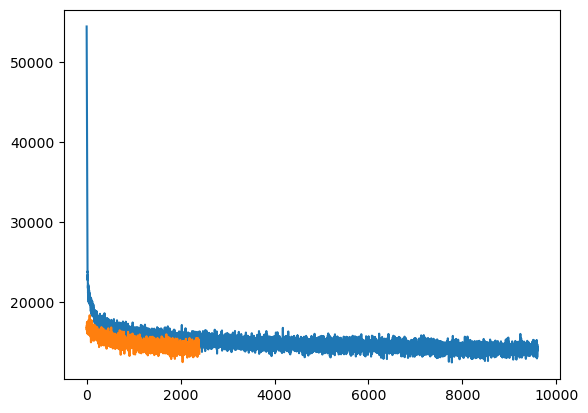

In [23]:
train_loss_tensor = torch.stack(history["train_loss"])
train_loss_np = train_loss_tensor.to('cpu').detach().numpy().copy()
plt.plot(train_loss_np)
val_loss_tensor = torch.stack(history["val_loss"])
val_loss_np = val_loss_tensor.to('cpu').detach().numpy().copy()
plt.plot(val_loss_np)
ave_tensor = torch.stack(history["ave"])
log_var_tensor = torch.stack(history["log_dev"])
z_tensor = torch.stack(history["z"])
labels_tensor = torch.stack(history["labels"])
print(ave_tensor.size())   #torch.Size([9600, 100, 2])
print(log_var_tensor.size())   #torch.Size([9600, 100, 2])
print(z_tensor.size())   #torch.Size([9600, 100, 2])
print(labels_tensor.size())   #torch.Size([9600, 100])

In [24]:
ave_np = ave_tensor.to('cpu').detach().numpy().copy()
log_var_np = log_var_tensor.to('cpu').detach().numpy().copy()
z_np = z_tensor.to('cpu').detach().numpy().copy()
labels_np = labels_tensor.to('cpu').detach().numpy().copy()
print(ave_np.shape)   #(9600, 100, 2)
print(log_var_np.shape)   #(9600, 100, 2)
print(z_np.shape)   #(9600, 100, 2)
print(labels_np.shape)   #(9600, 100)
map_keyword = "tab10"
cmap = plt.get_cmap(map_keyword)

(9600, 100, 2)
(9600, 100, 2)
(9600, 100, 2)
(9600, 100)


VAE(
  (encoder): Encoder(
    (lr): Linear(in_features=784, out_features=300, bias=True)
    (lr2): Linear(in_features=300, out_features=100, bias=True)
    (lr_ave): Linear(in_features=100, out_features=2, bias=True)
    (lr_dev): Linear(in_features=100, out_features=2, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lr): Linear(in_features=2, out_features=100, bias=True)
    (lr2): Linear(in_features=100, out_features=300, bias=True)
    (lr3): Linear(in_features=300, out_features=784, bias=True)
    (relu): ReLU()
  )
)

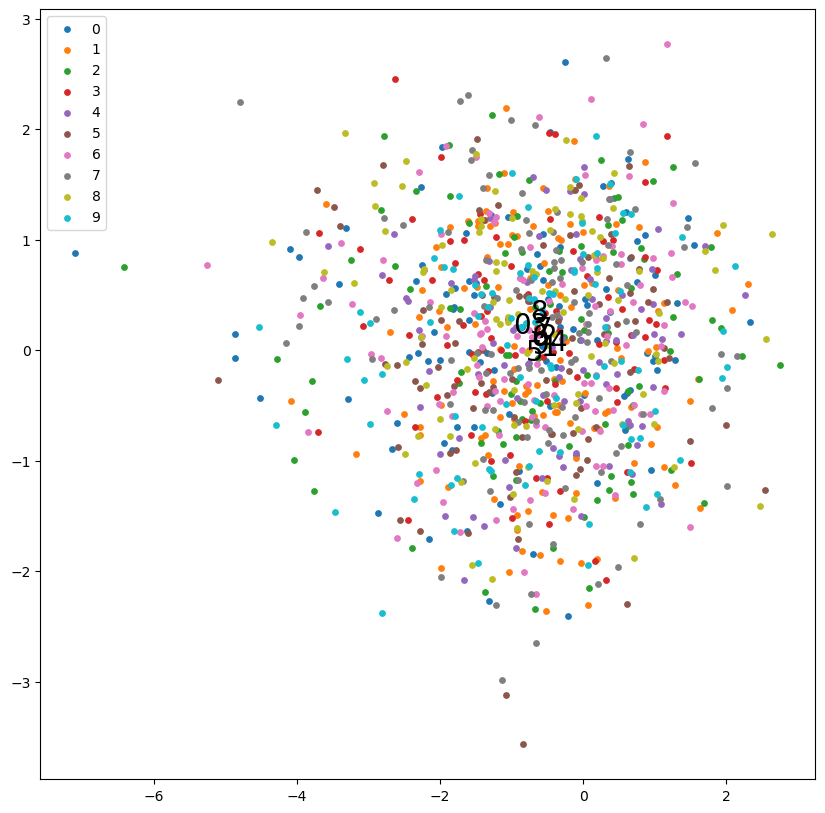

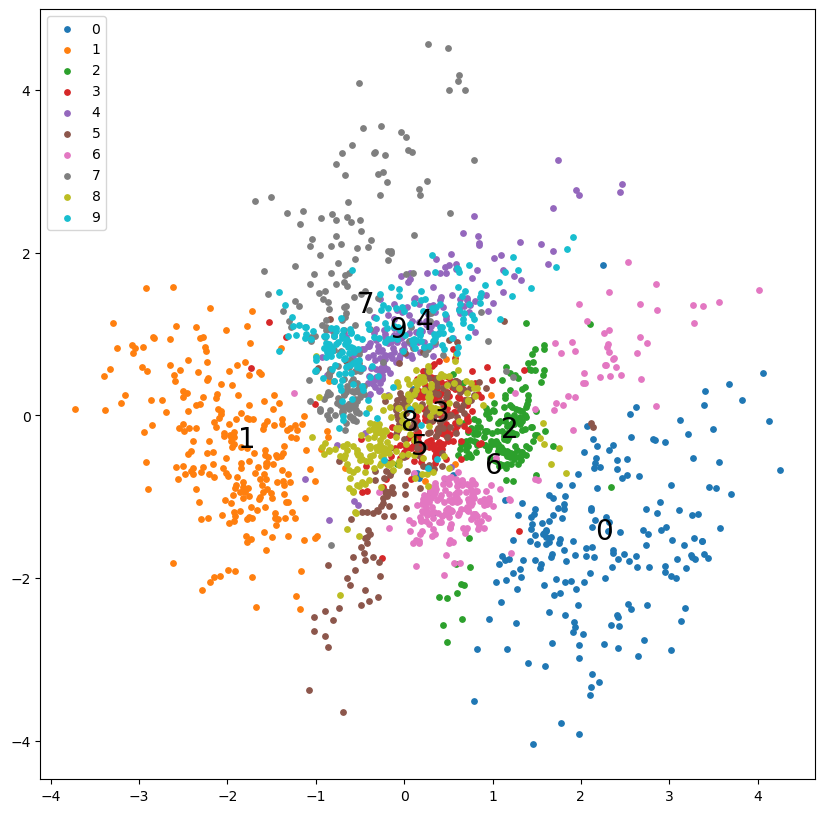

In [25]:
batch_num =10
plt.figure(figsize=[10,10])
for label in range(10):
  x = z_np[:batch_num,:,0][labels_np[:batch_num,:] == label]
  y = z_np[:batch_num,:,1][labels_np[:batch_num,:] == label]
  plt.scatter(x, y, color=cmap(label/9), label=label, s=15)
  plt.annotate(label, xy=(np.mean(x),np.mean(y)),size=20,color="black")
plt.legend(loc="upper left")
batch_num = 9580
plt.figure(figsize=[10,10])
for label in range(10):
  x = z_np[batch_num:,:,0][labels_np[batch_num:,:] == label]
  y = z_np[batch_num:,:,1][labels_np[batch_num:,:] == label]
  plt.scatter(x, y, color=cmap(label/9), label=label, s=15)
  plt.annotate(label, xy=(np.mean(x),np.mean(y)),size=20,color="black")
plt.legend(loc="upper left")
model.to("cpu")

In [27]:
label = 0
x_zero_mean = np.mean(ave_np[batch_num:,:,0][labels_np[batch_num:,:] == label])   #x軸の平均値
y_zero_mean = np.mean(ave_np[batch_num:,:,1][labels_np[batch_num:,:] == label])   #y軸の平均値
z_zero = torch.tensor([x_zero_mean,y_zero_mean], dtype = torch.float32)


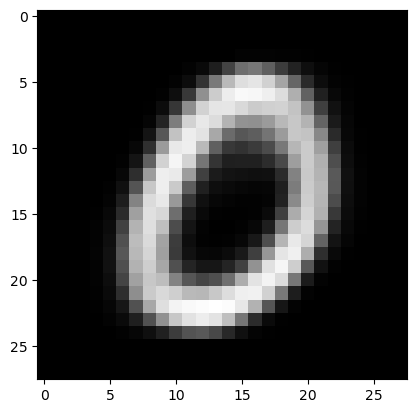

In [28]:
output = model.decoder(z_zero)
np_output = output.to('cpu').detach().numpy().copy()
np_image = np.reshape(np_output, (28, 28))
plt.imshow(np_image, cmap='gray')
label = 1
x_one_mean = np.mean(ave_np[batch_num:,:,0][labels_np[batch_num:,:] == label])   #x軸の平均値
y_one_mean = np.mean(ave_np[batch_num:,:,1][labels_np[batch_num:,:] == label])   #y軸の平均値
z_one = torch.tensor([x_one_mean,y_one_mean], dtype = torch.float32)

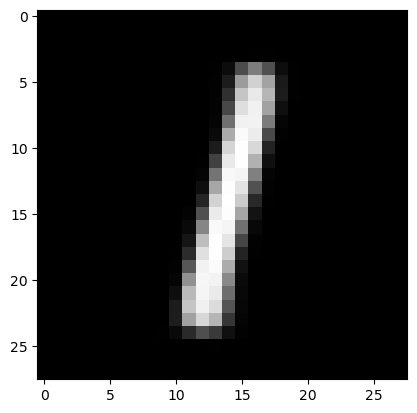

In [29]:
output = model.decoder(z_one)
np_output = output.to('cpu').detach().numpy().copy()
np_image = np.reshape(np_output, (28, 28))
plt.imshow(np_image, cmap='gray')
def plot(frame):
    plt.cla()
    z_zerotoone = ((99 - frame) * z_zero +  frame * z_one) / 99
    output = model.decoder(z_zerotoone)
    np_output = output.detach().numpy().copy()
    np_image = np.reshape(np_output, (28, 28))
    plt.imshow(np_image, cmap='gray')
    plt.xticks([]);plt.yticks([])
    plt.title("frame={}".format(frame))

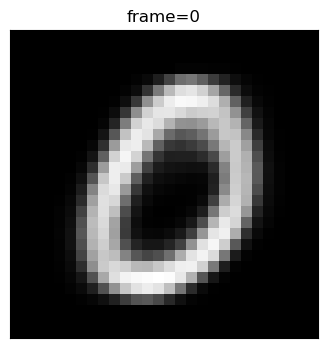

In [30]:
def plot(frame):
    plt.cla()
    z_zerotoone = ((99 - frame) * z_zero +  frame * z_one) / 99
    output = model.decoder(z_zerotoone)
    np_output = output.detach().numpy().copy()
    np_image = np.reshape(np_output, (28, 28))
    plt.imshow(np_image, cmap='gray')
    plt.xticks([]);plt.yticks([])
    plt.title("frame={}".format(frame))

fig = plt.figure(figsize=(4,4))
ani = animation.FuncAnimation(fig, plot, frames=99, interval=100)
rc('animation', html='jshtml')
ani